In [30]:
!wget http://www.kasprowski.pl/datasets/weather.zip
!unzip weather.zip;


--2024-11-15 08:58:56--  http://www.kasprowski.pl/datasets/weather.zip
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95380686 (91M) [application/zip]
Saving to: ‘weather.zip.1’

weather.zip.1       100%[===================>]  90.96M  11.7MB/s    in 8.4s    

2024-11-15 08:59:05 (10.8 MB/s) - ‘weather.zip.1’ saved [95380686/95380686]

Archive:  weather.zip
replace weather/cloudy/cloudy1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace weather/cloudy/cloudy10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [25]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, RMSprop
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [6]:
# Function to load images
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        if not os.path.isdir(indir + '/' + class_dir):
            continue
        print("Loading:", class_dir)
        for file in os.listdir(indir + '/' + class_dir):
            image = cv2.imread("{}/{}/{}".format(indir, class_dir, file))
            # if image is None:
            #    continue
            image = cv2.resize(image, (64, 64))
            samples.append(image)
            labels.append(class_dir)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples, labels

In [7]:
# Load dataset
DATASET_PATH = "weather"
samples, labels = load_img(DATASET_PATH)
print('Loaded', len(samples), 'samples')
print('Classes:', set(labels))

Loading: sunrise
Loading: shine
Loading: rain
Loading: cloudy
Loaded 1123 samples
Classes: {'sunrise', 'rain', 'cloudy', 'shine'}


In [9]:
# Original samples and labels
org_samples = samples
org_labels = labels

# Prepare data for binary classification
binary_classes = ['cloudy', 'sunrise']
binary_mask = np.isin(labels, binary_classes)
samples_binary = org_samples[binary_mask]
labels_binary = org_labels[binary_mask]

# Encode binary labels
lb_binary = LabelBinarizer()
labels_binary = lb_binary.fit_transform(labels_binary)

# Split data into train and test sets
trainSamples_bin, testSamples_bin, trainLabels_bin, testLabels_bin = train_test_split(
    samples_binary / 255.0, labels_binary, random_state=22)

In [10]:
# Binary classification model
model_bin = Sequential([
    Conv2D(16, (3, 3), padding="same", input_shape=(64, 64, 3)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512),
    Activation("relu"),
    Dense(1),
    Activation("sigmoid")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model_bin.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# Train binary classification model
history_bin = model_bin.fit(trainSamples_bin, trainLabels_bin, epochs=10, validation_data=(testSamples_bin, testLabels_bin))


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.8608 - loss: 0.5627 - val_accuracy: 0.6182 - val_loss: 0.7661
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9842 - loss: 0.0755 - val_accuracy: 0.9758 - val_loss: 0.0709
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.9940 - loss: 0.0251 - val_accuracy: 0.9818 - val_loss: 0.0521
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.9844 - loss: 0.1218 - val_accuracy: 0.9879 - val_loss: 0.0350
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9987 - loss: 0.0063 - val_accuracy: 0.9818 - val_loss: 0.0577
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9987 - loss: 0.0114 - val_accuracy: 0.9697 - val_loss: 0.0923
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9636 - val_loss: 0.1252
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9967 - loss: 0.0034 - val_accuracy: 0

In [12]:
# Evaluate binary model
binary_pred = (model_bin.predict(testSamples_bin) > 0.5).astype(int)

print("Binary Confusion Matrix:")
print(confusion_matrix(testLabels_bin, binary_pred))
print("Classification Report:\n", classification_report(testLabels_bin, binary_pred))
print("Cohen's Kappa:", cohen_kappa_score(testLabels_bin, binary_pred))
print("Accuracy:", accuracy_score(testLabels_bin, binary_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Binary Confusion Matrix:
[[71  1]
 [ 6 87]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.99      0.94      0.96        93

    accuracy                           0.96       165
   macro avg       0.96      0.96      0.96       165
weighted avg       0.96      0.96      0.96       165

Cohen's Kappa: 0.9144254278728606
Accuracy: 0.9575757575757575


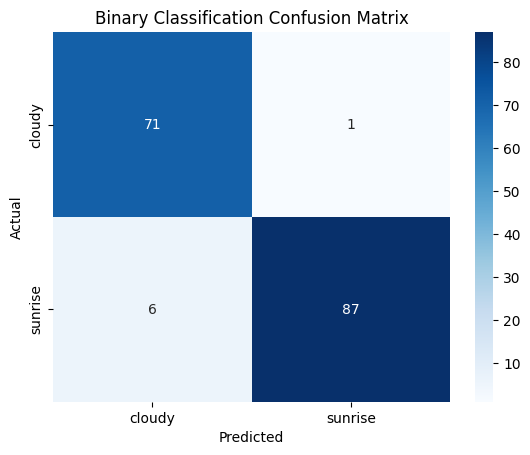

In [13]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(testLabels_bin, binary_pred), annot=True, fmt='d', cmap='Blues', xticklabels=binary_classes, yticklabels=binary_classes)
plt.title("Binary Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [20]:
# Prepare data to multi-class classification
lb_multi = LabelBinarizer()
labels_multi = lb_multi.fit_transform(org_labels)

# Split data into train and test
trainSamples_multi, testSamples_multi, trainLabels_multi, testLabels_multi = train_test_split(
    org_samples / 255.0, labels_multi, random_state=22)

# Multi-class classification model
model_multi = Sequential([
    Conv2D(32, (3, 3), padding="same", input_shape=(64, 64, 3)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, kernel_regularizer=l2(0.001)),
    Activation("relu"),
    Dropout(0.5),
    Dense(len(lb_multi.classes_)),
    Activation("softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model_multi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Train multi-class classification model
batch_size = 32
train_augmented = data_gen.flow(trainSamples_multi, trainLabels_multi, batch_size=batch_size)
history_multi = model_multi.fit(
    train_augmented,
    steps_per_epoch=len(trainSamples_multi) // batch_size,
    validation_data=(testSamples_multi, testLabels_multi),
    epochs=25
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 413ms/step - accuracy: 0.4871 - loss: 4.7805 - val_accuracy: 0.7224 - val_loss: 1.5637
Epoch 2/25
 1/26 ━━━━━━━━━━━━━━━━━━━━ 13s 543ms/step - accuracy: 0.6562 - loss: 1.7644

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6562 - loss: 1.7644 - val_accuracy: 0.7082 - val_loss: 1.5766
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 439ms/step - accuracy: 0.7195 - loss: 1.3169 - val_accuracy: 0.3737 - val_loss: 1.8276
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6875 - loss: 1.1218 - val_accuracy: 0.3772 - val_loss: 1.8415
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 439ms/step - accuracy: 0.7756 - loss: 1.1983 - val_accuracy: 0.3274 - val_loss: 2.2141
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8438 - loss: 1.1284 - val_accuracy: 0.3274 - val_loss: 2.1933
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 439ms/step - accuracy: 0.8035 - loss: 1.1421 - val_accuracy: 0.3416 - val_loss: 2.4207
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8438 - loss: 0.9722 - val_accuracy: 0.3310 - val_loss: 2.4625
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - accuracy: 0.8203 - loss: 1.0492 - val_accuracy: 0.2989 - val_

In [22]:
# Evaluate multi-class model
multi_pred = np.argmax(model_multi.predict(testSamples_multi), axis=1)
multi_true = np.argmax(testLabels_multi, axis=1)

print("Improved Multi-class Confusion Matrix:")
print(confusion_matrix(multi_true, multi_pred))
print("Classification Report:\n", classification_report(multi_true, multi_pred, target_names=lb_multi.classes_))
print("Cohen's Kappa:", cohen_kappa_score(multi_true, multi_pred))
print("Accuracy:", accuracy_score(multi_true, multi_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step
Improved Multi-class Confusion Matrix:
[[75  0  8  0]
 [28 16  2  0]
 [10  0 48  0]
 [21  0  1 72]]
Classification Report:
               precision    recall  f1-score   support

      cloudy       0.56      0.90      0.69        83
        rain       1.00      0.35      0.52        46
       shine       0.81      0.83      0.82        58
     sunrise       1.00      0.77      0.87        94

    accuracy                           0.75       281
   macro avg       0.84      0.71      0.72       281
weighted avg       0.83      0.75      0.75       281

Cohen's Kappa: 0.6543847627079928
Accuracy: 0.7508896797153025


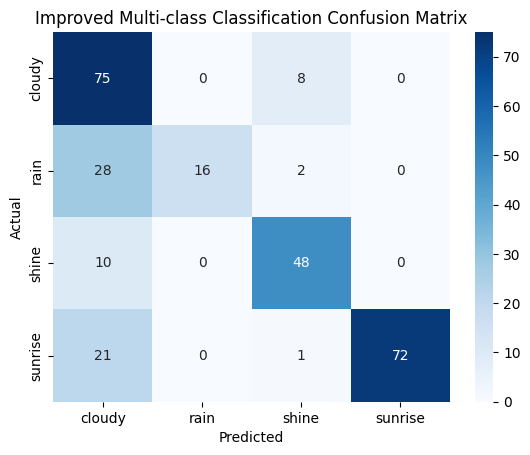

In [23]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(multi_true, multi_pred), annot=True, fmt='d', cmap='Blues', xticklabels=lb_multi.classes_, yticklabels=lb_multi.classes_)
plt.title("Improved Multi-class Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [26]:
# ADDITION: Transfer Learning - MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

# Build model
model_multi_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(lb_multi.classes_), activation='softmax')
])

# Compilation with RMSprop
model_multi_tl.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



<ipython-input-26-f0c99873afbc>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(64, 64, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# Train multi-class model with Transfer Learning
train_augmented = data_gen.flow(trainSamples_multi, trainLabels_multi, batch_size=32)
history_multi_tl = model_multi_tl.fit(
    train_augmented,
    steps_per_epoch=len(trainSamples_multi) // 32,
    validation_data=(testSamples_multi, testLabels_multi),
    epochs=25
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - accuracy: 0.3291 - loss: 1.5665 - val_accuracy: 0.6441 - val_loss: 1.0325
Epoch 2/25
 1/26 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.3750 - loss: 1.6870

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3750 - loss: 1.6870 - val_accuracy: 0.6370 - val_loss: 1.0281
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.4703 - loss: 1.2612 - val_accuracy: 0.7509 - val_loss: 0.8379
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5000 - loss: 1.2962 - val_accuracy: 0.7509 - val_loss: 0.8331
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.5962 - loss: 1.0549 - val_accuracy: 0.7758 - val_loss: 0.7225
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5625 - loss: 1.0482 - val_accuracy: 0.7758 - val_loss: 0.7187
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6622 - loss: 0.9194 - val_accuracy: 0.7936 - val_loss: 0.6465
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6562 - loss: 0.9171 - val_accuracy: 0.8114 - val_loss: 0.6386
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.6755 - loss: 0.8298 - val_accuracy: 0.8256 - val_los

In [28]:
# Evaluate multi-class model
multi_pred_tl = np.argmax(model_multi_tl.predict(testSamples_multi), axis=1)
multi_true_tl = np.argmax(testLabels_multi, axis=1)

print("Transfer Learning Multi-class Confusion Matrix:")
print(confusion_matrix(multi_true_tl, multi_pred_tl))
print("Classification Report:\n", classification_report(multi_true_tl, multi_pred_tl, target_names=lb_multi.classes_))
print("Cohen's Kappa:", cohen_kappa_score(multi_true_tl, multi_pred_tl))
print("Accuracy:", accuracy_score(multi_true_tl, multi_pred_tl))



9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step
Transfer Learning Multi-class Confusion Matrix:
[[67  2  7  7]
 [ 2 41  1  2]
 [ 3  3 44  8]
 [ 0  1  2 91]]
Classification Report:
               precision    recall  f1-score   support

      cloudy       0.93      0.81      0.86        83
        rain       0.87      0.89      0.88        46
       shine       0.81      0.76      0.79        58
     sunrise       0.84      0.97      0.90        94

    accuracy                           0.86       281
   macro avg       0.87      0.86      0.86       281
weighted avg       0.87      0.86      0.86       281

Cohen's Kappa: 0.8144215227932359
Accuracy: 0.8647686832740213


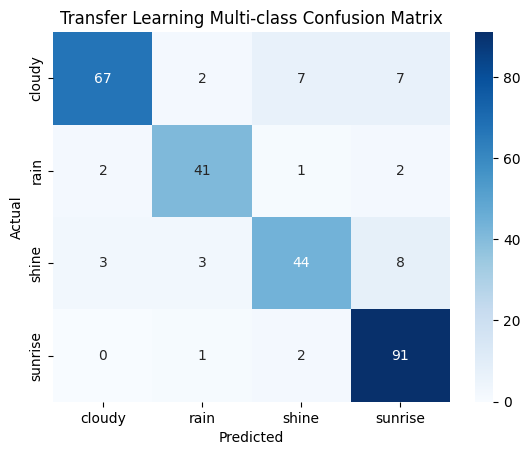

In [29]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(multi_true_tl, multi_pred_tl), annot=True, fmt='d', cmap='Blues', xticklabels=lb_multi.classes_, yticklabels=lb_multi.classes_)
plt.title("Transfer Learning Multi-class Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


WNIOSKI:
- Binary Classification: Prosty model CNN osiągnął bardzo dobre wyniki (96% accuracy). Wynika to z łatwości rozróżnienia dwóch klas (cloudy, sunrise) w zbiorze.
- Multi-class Classification: Podczas klasyfikacji czterech klas zauważono spadek dokładności (75%), co może być związane z większą trudnością zadania, np. podobieństwem klas (w tym przypadku: cloudy i rain)
- Transfer Learning: było dodatkowym krokiem, który nie był wymagany w zadaniu, ale miał na celu sprawdzenie potencjalnej poprawy wyników co się udało gdyż osiągnął accuracy na poziomie 86% (lepszy wynik niż Multi-class Classification)

Kluczowe czynniki wpływające na wyniki:
- rozdzielczość obrazów (ogranicza ilość informacji dostępnych dla modelu)
- regularyzacja pomogła zminimalizaować przeuczenie w Multi-class modelu
